<a href="https://colab.research.google.com/github/lasseufpa/dsp-notebooks/blob/main/Ch1_Signals/image_quantization.ipynb
" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install requirements and learn how to use the lasse-py module

- Install https://github.com/lasseufpa/lasse-py on your machine
- Read its README.md file
- Make sure Python can find the lasse-py module by: 1) configuring your environment variable PYTHONPATH, 2) installing the module with its setup.py or 3) using sys.path.append as below.

Make sure everything is properly installed.

In [3]:
# Clone the repository if running in Colab and install all the dependencies
if 'google.colab' in str(get_ipython()):
    import sys
    import os
    try:
      !git clone https://github.com/lasseufpa/lasse-py.git
    except:
      print("lasse-py is already in the contents")
    %cd lasse-py
    !pip install -r requirements.txt
else:
    import sys
    # make sure to set the path to where you have cloned the LASSE repository
    # under your folder specified below, you need to find lasse/dsp, lasse/audio, etc.
    sys.path.append(r"C:\github\lasse-py")
    import lasse.dsp  # verify if the module is correctly imported

# Execute some tests with quantization

Notice:
- Each pixel is represented by three bytes, representing three color-values (RGB)
- It is not recommended to do signal processing with pixels represented by char (8 bits) variables. Roundoff errors will be significant. Convert them to real numbers (float or double)
- To visualize the image, you may have to convert back from real numbers to unsigned char (values in the range: 0 to 255)
- The design of a quantizer must take in account the dynamic range and statistics of the input signal. Check them with histograms.
- Two figures of merit to evaluate your quantizer are MSE and PSNR. Get familiar with them.

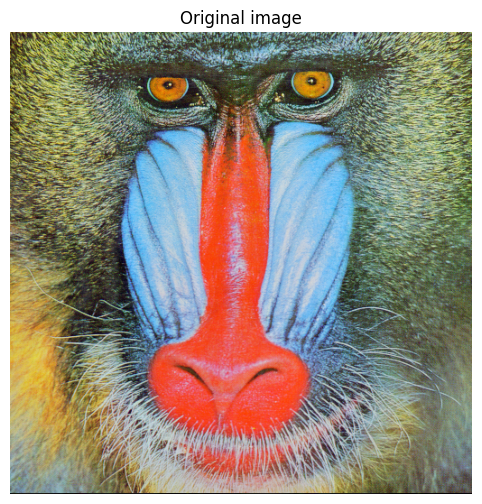

Maximum quantized value: 111.5625
Minimum quantized value: 0.0


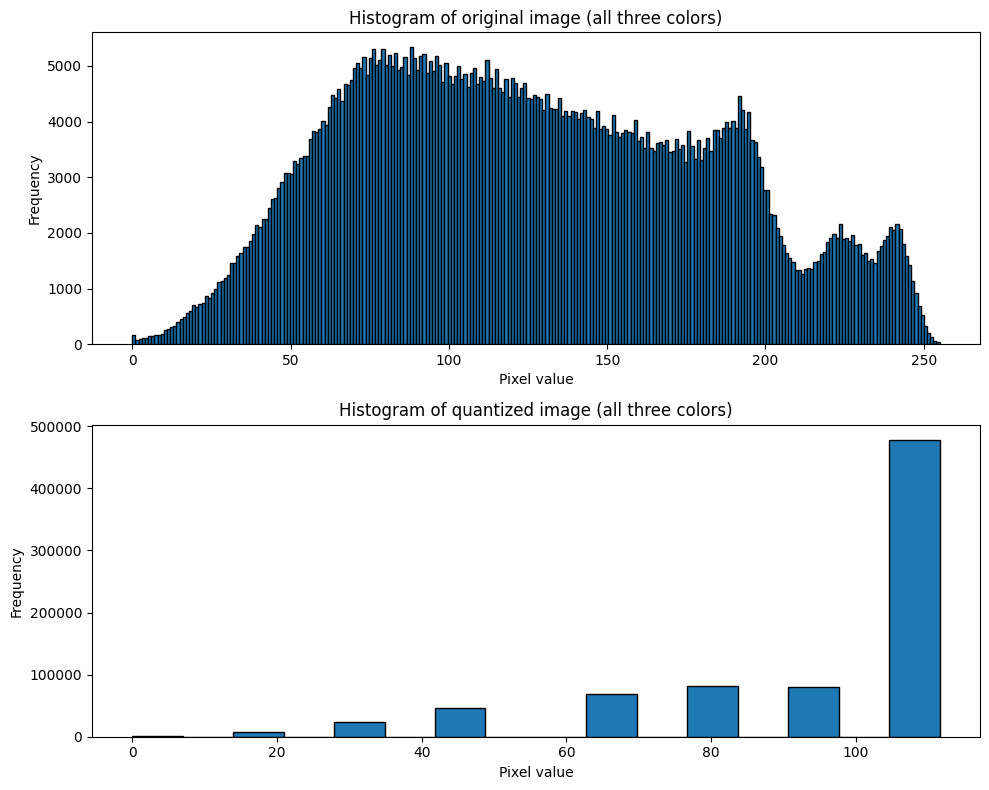

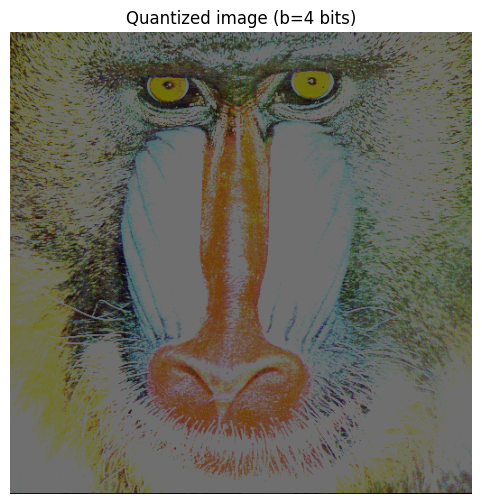

Mean Square Error (MSE): 2563.904644012451
Peak Signal-to-Noise Ratio (PSNR): 14.04 dB


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from lasse.dsp.scalar_quantization import UniformQuantizer
import requests
from io import BytesIO

# 1) Read from file and show image
url = "https://raw.githubusercontent.com/lasseufpa/dsp-notebooks/main/Ch1_Signals/input_data/baboon.tiff"
response = requests.get(url)
x = Image.open(BytesIO(response.content))
x = np.array(x)  # convert PIL image to numpy array

plt.figure(figsize=(10, 6))
plt.imshow(x)
plt.title('Original image')
plt.axis('off')
plt.show()

# 2) Quantize image and show
x_double = x.astype(np.float64)  # convert from uint8 to double
b = 4  # number of bits for quantization
delta = 256 / (2 ** (b - 1))  # quantization step

# Use the UniformQuantizer from lasse-py. Create the object first
uniformQuantizer = UniformQuantizer(
    num_bits=b,
    xmin=0,
    xmax=255,
    forceZeroLevel=True
)

# Quantize the image
xq_double, x_indices = uniformQuantizer.quantize_numpy_array(x_double)

print(f"Maximum quantized value: {np.max(xq_double)}")
print(f"Minimum quantized value: {np.min(xq_double)}")

# Plot histograms
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].hist(x_double.flatten(), bins=256, edgecolor='black')
axes[0].set_title('Histogram of original image (all three colors)')
axes[0].set_xlabel('Pixel value')
axes[0].set_ylabel('Frequency')

axes[1].hist(xq_double.flatten(), bins=2**b, edgecolor='black')
axes[1].set_title('Histogram of quantized image (all three colors)')
axes[1].set_xlabel('Pixel value')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# Convert from double to uint8 for display
xq = np.clip(xq_double, 0, 255).astype(np.uint8)

plt.figure(figsize=(10, 6))
plt.imshow(xq)
plt.title(f'Quantized image (b={b} bits)')
plt.axis('off')
plt.show()

# 3) Calculate MSE
meanSquareError = np.mean((x.astype(np.float64).flatten() - xq.astype(np.float64).flatten()) ** 2)
print(f"Mean Square Error (MSE): {meanSquareError}")
print(f"Peak Signal-to-Noise Ratio (PSNR): {10 * np.log10(255**2 / meanSquareError):.2f} dB")

# Step 3: Rate-Distortion Analysis using Uniform Quantizers

**Rate-distortion theory** is a classic signal compression topic. A classic textbook is "Rate distortion theory: A mathematical basis for data compression", by Toby Berger, Prentice-Hall, 1971.

From the MSE distortion measure, one can calculate the **peak signal-to-noise ratio (PSNR)** using the formula: [PSNR on Wikipedia](https://en.wikipedia.org/wiki/Peak_signal-to_noise_ratio)


# Task 1

Vary the number of bits of your uniform quantizer from 3 to 21 bits per pixel (which corresponds to 1 to 7 bits per color value per pixel) and calculate the mean squared error (MSE) in each case for both images. 
You shall use lasse.dsp.scalar_quantization from lasse-py. If you have suggestions for improving this module, share with the class and consider pull requests.

This will create D(R) curves, where the rate R is the abscissa and the distortion D is the ordinate. Instead of MSE, use PSNR in dB as the distortion measure.

Obtain D(R) curves for two images: the baboon used previously (also called mandrill) and another image that you choose. 

# Step 4: Non-Uniform Quantizers Seeking Optimality

Learn about non-uniform quantizers. 
The optimal quantizer depends on the input signal statistics.
When implementing quantization, the designed should optimize the quantizer to minimize distortion (e.g., MSE). The disadvantage of non-uniform quantizers is that they are more computationally demand to design and quantize its input.

Non-uniform scalar quantizers can be optimally designed using the Lloyd-Max algorithm.

Search for the algorithm online or find Python implementations equivalent to MATLAB's `lloyds` function.

Note that the Lloyd–Max algorithm was conceived to design scalar quantizers. It was later extended by Linde, Buzo and Gray (LBG) to work for vectors and it is used in "vector quantization". The LBG algorithm (also called Generalized Lloyd–Max algorithm or GLA) is very similar to the K-means clustering algorithm (from sklearn.cluster import KMeans). These 3 algorithms (original Lloyd-Max, GLA and K-Means) differ by: a) initialization strategy, b) empty centroid / cluster handling, c) tie-breaking rules and other details.


# Task 2

Design non-uniform quantizers for each of your 2 images and compare with the uniform quantizers you had.

Provide a complete description of your quantizers for 3 to 6 bits per pixel, comparing uniform and non-uniform quantizers:
- Provide the quantizer's output levels
- Define the decision thresholds
- Construct the output versus input relationship (the "quantizer stair")

Note you will design 4 non-uniform quantizers to study the suggested range of 3 to 6 bits per pixel. And compare them with 4 uniform quantizers.

Superimpose the 4 D(R) curves (for 2 images, with uniform and non-uniform quantizers) for a given number of quantization bits.

Feel free to use a good histogram analysis, for instance, presenting histograms for the quantized and original pixel values for both images. Compare the distributions to visualize the effect of quantization on the image data.


 

# Task 3

Think about this: the only scenario in which a uniform quantizer is optimum is when the input data has a uniform distribution. Do you agree? How do you explain this intuitively?

# Task 4

SNR Improvement Rule-of-Thumb

Use this experiment to evaluate the rule-of-thumb that states an extra quantization bit improves SNR by 6 dB. Superimpose your experimental data with PSNR in dB and a theoretical curve on the same plot. The slope of the  theoretical curve is 6 dB per bit, but you need to adjust the point it intersects with the y-axis.

Comment if you find a good agreement between this rule-of-thumb and your experimental results, explaining eventual discrepancies.

# Task 5

You do not need to execute code, but think about the following: would you obtain better results by adopting vector quantization (VQ) to explore the correlation among RGB values of pixels in a given image? Think about RGB values that never occur and could be avoided by VQ, but not by scalar quantization because scalar quantization assumes the 3 RGB values are independent.